In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
from io import BytesIO
from IPython.display import clear_output, display
import ipywidgets as widgets
import glob
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm

In [2]:
# wget에서 -nc 옵션은 두번 다운받지 않기 위해...

!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget -nc https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
!wget -nc -O kandinsky5.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget -nc -O Moon_jellyfish_at_Gota_Sagher.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/Moon_jellyfish_at_Gota_Sagher.JPG/1200px-Moon_jellyfish_at_Gota_Sagher.JPG

!ffmpeg -i Moon_jellyfish_at_Gota_Sagher.jpg -y -s 557x418 Moon_jellyfish_at_Gota_Sagher.jpg

--2020-12-23 14:51:51--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.7.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M   111MB/s    in 0.4s    

2020-12-23 14:51:52 (111 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 
--2020-12-23 14:51:53--  https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.12.240, 172.217.15.112, ...
Connecting to

In [3]:
! ls

imagenet_comp_graph_label_strings.txt  Moon_jellyfish_at_Gota_Sagher.jpg
inception5h.zip			       sample_data
kandinsky5.jpg			       tensorflow_inception_graph.pb
LICENSE				       YellowLabradorLooking_new.jpg


In [4]:
# 변형할 이미지 파일 (더) 가져오기
from google.colab import files
uploaded = files.upload()

Saving starry_night.jpg to starry_night.jpg


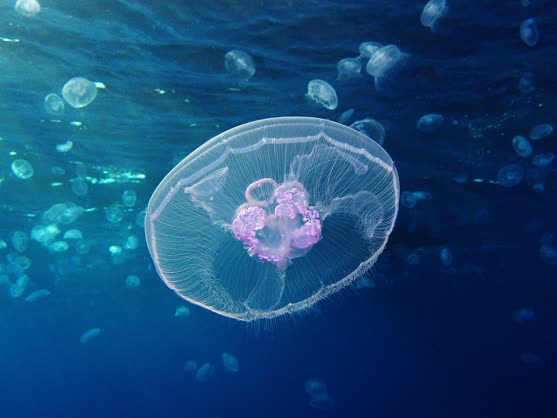

In [5]:
img = Image.open('Moon_jellyfish_at_Gota_Sagher.jpg')  # 'YellowLabradorLooking_new.jpg'
display(img)

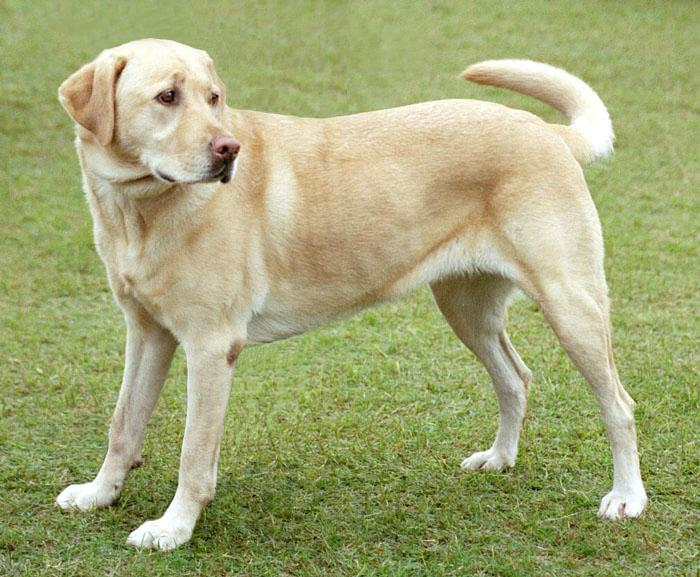

In [6]:
def showarray(a, fmt='jpeg'):
    if type(a) is not np.ndarray:
        a = a.numpy()  
    a = np.uint8(np.clip(a, 0, 255))
    im = Image.fromarray(a)
    display(im)

file_contents = tf.io.read_file('YellowLabradorLooking_new.jpg')
img0 = tf.image.decode_image(file_contents)  # unit8
showarray(img0)

# 1. The core deepdream code
## 1-1. Model 만들기

In [7]:
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

def resize(img, new_size):
    return tf.image.resize(img[np.newaxis,:], new_size)[0]  # input: numpy array --> output: tensor

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, model_fn, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = tf.roll(tf.roll(img, sx, 1), sy, 0)
    gradients = tf.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            
            with tf.GradientTape() as tape:
                tape.watch(img_shift)
                sub = img_shift[y:y+tile_size,x:x+tile_size]
                loss = tf.math.reduce_mean(model_fn(sub[None]))
            
            gradients = gradients + tape.gradient(loss, img_shift)
            

    imggrad = tf.roll(tf.roll(gradients, -sx, 1), -sy, 0)
    
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(model,layer_name, input_img,feature_channel=None, show_steps = True,):
    # input_img: numpy array (H,W,C} ---> not batch
    # Collapse the optimization objective to a single number (the loss)
    if feature_channel:
        model_fn = model.get_layer_neuron_function(layer_name,feature_channel)
    else:
        model_fn = model.get_layer_function(layer_name)

    if model_fn is None:
        return input_img

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img.copy()
    octaves = []  # shape: [577, 700, 3], [412, 500, 3], [294, 357, 3]
    for i in range(octave_n-1):  # 원본이 있으니까 하나 적게 만든다.
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi   
        for i in range(iter_n):
            img = calc_grad_tiled(img,model_fn)
        if show_steps:
            clear_output()
            showarray(img)
    return img.numpy()  # return numpy array (H,W,C)

class InceptionV1():
    def __init__(self,filepath):
        self.graph_def = tf.compat.v1.GraphDef()
        self.graph_def.ParseFromString(open(filepath,'rb').read())
        self.all_layers = [n.name for n in self.graph_def.node]
        self.import_graph = None

    
    def wrap_frozen_graph(self,graph_def, inputs, outputs):
        def _imports_graph_def():
            tf.compat.v1.import_graph_def(graph_def, name="")
        wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
        self.import_graph = wrapped_import.graph
        return wrapped_import.prune( tf.nest.map_structure(self.import_graph.as_graph_element, inputs),
                                     tf.nest.map_structure(self.import_graph.as_graph_element, outputs))

    def get_layer_function(self,layer_name):
        return self.wrap_frozen_graph( self.graph_def, inputs='input:0', outputs=f'{layer_name}:0')

    def get_layer_neuron_function(self,layer_name, feature_channel):

        fn = self.get_layer_function(layer_name)
        
        layer = self.import_graph.get_tensor_by_name(layer_name+':0')
        max_channel = int(layer.get_shape()[-1])
        if feature_channel >= max_channel:
            print(f"Feature channel exceeds size of layer {layer_name} feature space {max_channel}")
            print("Choose a smaller channel number.")

            return None
        
        return lambda x: fn(x)[:,:,:,feature_channel]

## 1-2. Deep Dream Image 생성하기

In [8]:
# Local PC에서 변형할 이미지 파일 가져오기
from google.colab import files
uploaded = files.upload()
! ls

Saving Moon_jellyfish_at_Gota_Sagher.jpg to Moon_jellyfish_at_Gota_Sagher.jpg
Saving mountain.jpg to mountain.jpg
Saving mountain2.jpg to mountain2.jpg
Saving mountain3.jpg to mountain3.jpg
Saving original_photo_deep_dream.jpg to original_photo_deep_dream.jpg
Saving sky.jpg to sky.jpg
Saving starry_night.jpg to starry_night.jpg
imagenet_comp_graph_label_strings.txt  mountain.jpg
inception5h.zip			       original_photo_deep_dream.jpg
kandinsky5.jpg			       sample_data
LICENSE				       sky.jpg
Moon_jellyfish_at_Gota_Sagher.jpg      starry_night.jpg
mountain2.jpg			       tensorflow_inception_graph.pb
mountain3.jpg			       YellowLabradorLooking_new.jpg


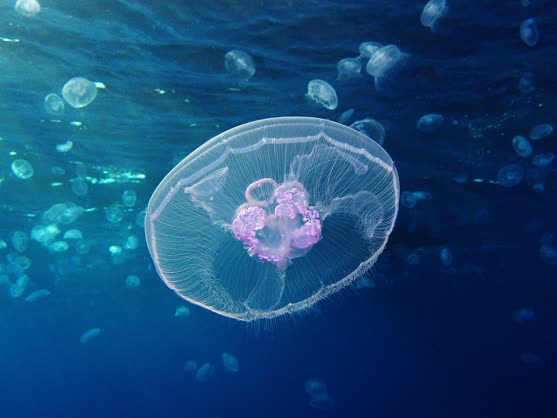

In [8]:
img_filename = 'Moon_jellyfish_at_Gota_Sagher.jpg'  #  'mountain2.jpg'  'YellowLabradorLooking_new.jpg'  'Moon_jellyfish_at_Gota_Sagher.jpg'

img0 = np.array(Image.open(img_filename),dtype=np.float32)
showarray(img0)

In [9]:
inceptin_model_path = 'tensorflow_inception_graph.pb'
model = InceptionV1(inceptin_model_path)
# model.all_layers   # layer의 이름을 확인할 수 있다.

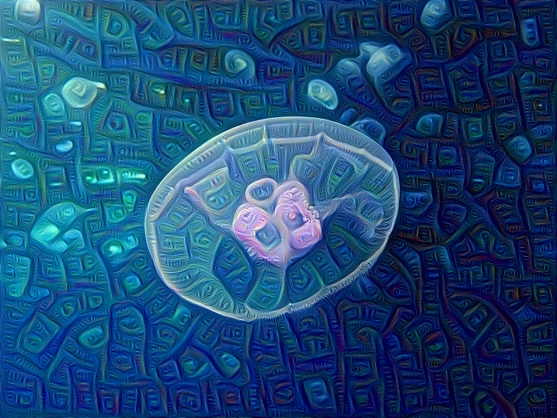

In [10]:
layer_name = 'mixed3a'
final = render_deepdream(model,layer_name, img0)

## 1-3. neuron 으로 부터 생성해 보기

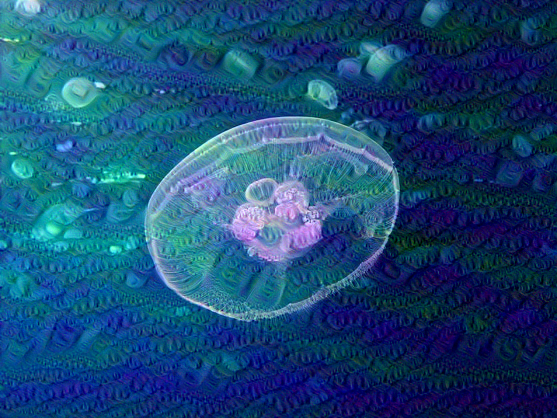

In [11]:
layer_name = 'mixed3a' #'mixed4d_3x3_bottleneck_pre_relu'
feature_channel = 88

final = render_deepdream(model,layer_name, img0,feature_channel)

# 2. Interactive Image 생성(GUI)

## 2-1. layer로 생성

In [12]:
input_file_list = sorted(glob.glob('*.jpg'))
wid_octave_n = widgets.IntSlider(value=4,min=1,max=10,step=1, description='octave_n:')
wid_octave_scale = widgets.BoundedFloatText(value=1.4, min=1.1,max=2.0,step=0.1,description='octave_scale:')
wid_iter_n = widgets.IntSlider(value=10,min=1,max=50,step=1, description='iter_n:')
wid_strength = widgets.IntSlider(value=200,min=0,max=1000,step=50, description='strength:')
wid_layer = widgets.Dropdown(value='mixed3a', options=["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"], description='layer:')
wid_input_file = widgets.Dropdown(options=input_file_list, description='image file:')

display(wid_octave_n,wid_octave_scale,wid_iter_n,wid_strength,wid_layer,wid_input_file)


IntSlider(value=4, description='octave_n:', max=10, min=1)

BoundedFloatText(value=1.4, description='octave_scale:', max=2.0, min=1.1, step=0.1)

IntSlider(value=10, description='iter_n:', max=50, min=1)

IntSlider(value=200, description='strength:', max=1000, step=50)

Dropdown(description='layer:', options=('mixed3a', 'mixed3b', 'mixed4a', 'mixed4c', 'mixed5a'), value='mixed3a…

Dropdown(description='image file:', options=('Moon_jellyfish_at_Gota_Sagher.jpg', 'YellowLabradorLooking_new.j…

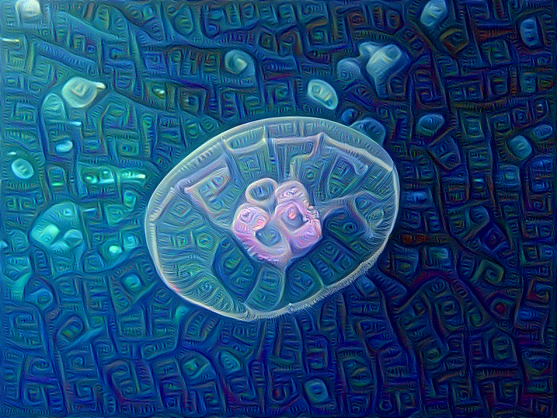

In [13]:
# 파라메터 조절 후, 여기 코드를 실행하면 됨.

octave_n=wid_octave_n.value
octave_scale = wid_octave_scale.value
iter_n = wid_iter_n.value
strength =  wid_strength.value
layer_name =  wid_layer.value
img0 = np.array(Image.open(wid_input_file.value),dtype=np.float32)
print(wid_input_file.value)
final = render_deepdream(model,layer_name, img0)

## 2-2. Deep Dream by a single neuron

In [14]:
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

input_file_list = sorted(glob.glob('*.jpg'))
wid_layer = widgets.Dropdown(value='mixed4d_3x3_bottleneck_pre_relu', options=["mixed4d_3x3_bottleneck_pre_relu","mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"], description='layer:')
wid_feature_channel = widgets.IntSlider(value=111,min=0,max=512,step=1, description='feature_channel:')

wid_input_file = widgets.Dropdown(options=input_file_list, description='image file:')

display(wid_layer,wid_feature_channel,wid_input_file)

Dropdown(description='layer:', options=('mixed4d_3x3_bottleneck_pre_relu', 'mixed3a', 'mixed3b', 'mixed4a', 'm…

IntSlider(value=111, description='feature_channel:', max=512)

Dropdown(description='image file:', options=('Moon_jellyfish_at_Gota_Sagher.jpg', 'YellowLabradorLooking_new.j…

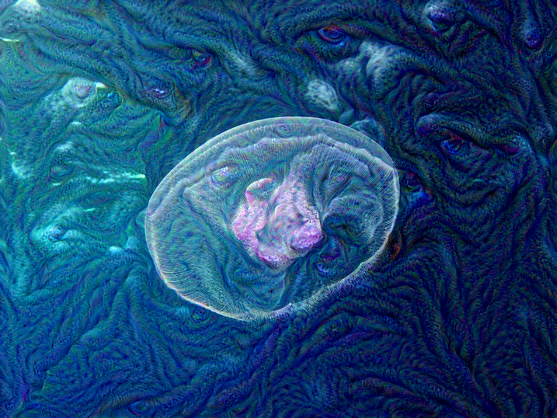

In [15]:
layer_name =  wid_layer.value
feature_channel = wid_feature_channel.value
img0 = np.array(Image.open(wid_input_file.value),dtype=np.float32)

print(wid_input_file.value)
final = render_deepdream(model,layer_name, img0,feature_channel)

# 3. Zooming iterative DeepDream

In [16]:
input_file_list = sorted(glob.glob('*.jpg'))

wid_layer = widgets.Dropdown(value='mixed5a', options=["mixed4d_3x3_bottleneck_pre_relu","mixed4e_3x3_pre_relu","mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"], description='layer:')
wid_iter_n = widgets.IntSlider(value=10,min=1,max=50,step=1, description='iter_n:')
wid_strength = widgets.IntSlider(value=200,min=0,max=1000,step=50, description='strength:')
wid_zooming_steps = widgets.IntSlider(value=20,min=0,max=512,step=1, description='zooming_steps:',style = {'description_width': 'initial'})
wid_zoom_factor = widgets.BoundedFloatText(value=1.1, min=1.0,max=3.0,step=0.1,description='zoom_factor:')
wid_input_file = widgets.Dropdown(options=input_file_list, description='image file:')
wid_random_zoom = widgets.Checkbox( value=False, description='Random Zoom Positioon',  disabled=False)

display(wid_layer,wid_iter_n,wid_strength,wid_zooming_steps,wid_zoom_factor,wid_input_file,wid_random_zoom)

Dropdown(description='layer:', index=2, options=('mixed4d_3x3_bottleneck_pre_relu', 'mixed4e_3x3_pre_relu', 'm…

IntSlider(value=10, description='iter_n:', max=50, min=1)

IntSlider(value=200, description='strength:', max=1000, step=50)

IntSlider(value=20, description='zooming_steps:', max=512, style=SliderStyle(description_width='initial'))

BoundedFloatText(value=1.1, description='zoom_factor:', max=3.0, min=1.0, step=0.1)

Dropdown(description='image file:', options=('Moon_jellyfish_at_Gota_Sagher.jpg', 'YellowLabradorLooking_new.j…

Checkbox(value=False, description='Random Zoom Positioon')

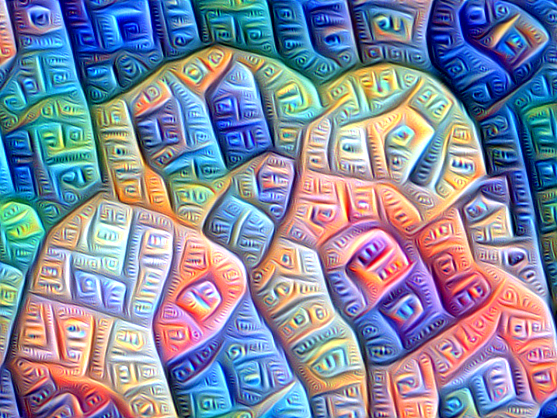

100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


In [17]:
!rm generated*.jpg

MAX_SIZE=700
octave_n = 4
octave_scale = 1.4

layer_name =  wid_layer.value
iter_n = wid_iter_n.value
strength =  wid_strength.value
zooming_steps = wid_zooming_steps.value
zoom_factor = wid_zoom_factor.value
random_flag=wid_random_zoom.value
img0 = np.array(Image.open(wid_input_file.value),dtype=np.float32)
print(wid_input_file.value)


frame = img0
img_y, img_x, _ = frame.shape
#print("image size: ",img_y,img_x)
if img_y > MAX_SIZE or img_x > MAX_SIZE:
    ratio = img_y/MAX_SIZE if img_y > img_x else img_x/MAX_SIZE
    newsize = np.int32(np.float32(frame.shape[:2])/ratio)
    frame = resize(frame, newsize).numpy()
    img_y, img_x, _ = frame.shape
    #print('new size: ', frame.shape)

for i in tqdm(range(zooming_steps)):
    frame = render_deepdream(model,layer_name, frame,show_steps=False)
    clear_output()
    showarray(frame)
    Image.fromarray(np.uint8(np.clip(frame, 0, 255))).save(f'generated_{i}.jpg')
    newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
    frame = resize(frame, newsize)
    if random_flag:
        e1 = max(0,int((newsize[0]-img_y)//2  + np.random.rand() *(newsize[0]-img_y)/2 -(newsize[0]-img_y)/4) )
        e2 = max(0,int((newsize[1]-img_x)//2  + np.random.rand() *(newsize[1]-img_x)/2 -(newsize[1]-img_x)/4) )
    else:
        e1 = (newsize[0]-img_y)//2 
        e2 = (newsize[1]-img_x)//2
    
    frame = frame[e1:e1+img_y,e2:e2+img_x,:].numpy()  # 이미지 중심 부분 추출  ---> 위치에 randomness를 추가하면?


# 4. Moving GIF 만들기

In [ ]:
origin_file  = 'Moon_jellyfish_at_Gota_Sagher.jpg'  # Moon_jellyfish_at_Gota_Sagher.jpg
image_files = natsorted(glob.glob('generated*.jpg'))

images = [Image.open(origin_file)]+ [Image.open(f) for f in image_files]
gif = images[0]
gif.save(fp="DeepDream.gif", format='gif', save_all=True, append_images=images[1:],duration=100)  # duration 지정

In [ ]:
# 다운로드 받기
from google.colab import files
files.download('DeepDream.gif')

In [ ]:
# gif 살펴보기:  ---> 파일 size가 크면 error 발생  ---> 이유????
from IPython.display import Image as Image2   # PIL Image와 이름이 같아서...
with open('DeepDream.gif','rb') as f:
    display(Image2(data=f.read(), format='png'))

# 5. Inception V1(GoogLeNet) Layer 살펴보기
- 위의 코드에서는 ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"] 외에 'mixed4d_3x3_bottleneck_pre_relu' layer에 대해서만 다루었다.
- 'mixed4d_3x3_bottleneck_pre_relu'외에도 가능한 layer에 대해서 살펴보자.

In [ ]:
all_layers = model.all_layers
all_conv_layers = [layer.replace('/conv','') for layer in all_layers if '/conv' in layer]
for i, layer in enumerate(all_conv_layers):
    print(layer, end=', ')
    if (i+1)%3==0:
        print('')

conv2d0_pre_relu, conv2d1_pre_relu, conv2d2_pre_relu, 
mixed3a_1x1_pre_relu, mixed3a_3x3_bottleneck_pre_relu, mixed3a_3x3_pre_relu, 
mixed3a_5x5_bottleneck_pre_relu, mixed3a_5x5_pre_relu, mixed3a_pool_reduce_pre_relu, 
mixed3b_1x1_pre_relu, mixed3b_3x3_bottleneck_pre_relu, mixed3b_3x3_pre_relu, 
mixed3b_5x5_bottleneck_pre_relu, mixed3b_5x5_pre_relu, mixed3b_pool_reduce_pre_relu, 
mixed4a_1x1_pre_relu, mixed4a_3x3_bottleneck_pre_relu, mixed4a_3x3_pre_relu, 
mixed4a_5x5_bottleneck_pre_relu, mixed4a_5x5_pre_relu, mixed4a_pool_reduce_pre_relu, 
mixed4b_1x1_pre_relu, mixed4b_3x3_bottleneck_pre_relu, mixed4b_3x3_pre_relu, 
mixed4b_5x5_bottleneck_pre_relu, mixed4b_5x5_pre_relu, mixed4b_pool_reduce_pre_relu, 
mixed4c_1x1_pre_relu, mixed4c_3x3_bottleneck_pre_relu, mixed4c_3x3_pre_relu, 
mixed4c_5x5_bottleneck_pre_relu, mixed4c_5x5_pre_relu, mixed4c_pool_reduce_pre_relu, 
mixed4d_1x1_pre_relu, mixed4d_3x3_bottleneck_pre_relu, mixed4d_3x3_pre_relu, 
mixed4d_5x5_bottleneck_pre_relu, mixed4d_5x5_pr

### Reference
 - https://colab.research.google.com/drive/1DWcrN9WXni58MbddvlShX0wF_oeo8W_0